# 0. Import Libraries

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import re
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Set up

In [59]:
# Where to save the figures

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "DSND_Project_1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    This function receives a figure title and returns the figure saved in a designated folder.
    The default setting creates a png file of resolution 300 with tight layout.
    There is a notification telling you that the figure is being saved.
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 2. Business understanding

This project aims to analyze the data from Boston Airbnb dataset and answer the following questions:

- What’s it like living in a Boston neighborhood?
- Overall, how do people rate Boston Airbnb’s (negative, neutral, or positive)?
- What are the factors that influence price?

# 3. Data understanding

## Overall information

In [60]:
listings = pd.read_csv('/Users/phoil/Downloads/ML/DSND_Term2/lessons/CRISP_DM/Boston AirBnB/listings.csv')

In [61]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [62]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [63]:
print("There are {} observations and {} features in this dataset. \n".format(listings.shape[0], listings.shape[1]))

print("There are {} numerical features in this dataset such as {}... \n".format(len(listings.select_dtypes(['float', 'int']).columns),
                                                                           ", ".join(list(listings.select_dtypes(['float', 'int']).columns)[0:5])))

print("There are {} categorical features in this dataset such as {}... \n".format(len(listings.select_dtypes(['object']).columns),
                                                                           ", ".join(list(listings.select_dtypes(['object']).columns)[0:5])))

There are 3585 observations and 95 features in this dataset. 

There are 33 numerical features in this dataset such as id, scrape_id, host_id, host_listings_count, host_total_listings_count... 

There are 62 categorical features in this dataset such as listing_url, last_scraped, name, summary, space... 



## Numerical attributes

In [64]:
# Select the numerical features
num_attribs = listings.select_dtypes(include=['float64', 'int64'])
num_attribs = num_attribs[num_attribs.columns]

In [65]:
# Create a table of missing numerical data with percentage
num_null_total = num_attribs.isnull().sum().sort_values(ascending=False)
num_null_pct = (num_attribs.isnull().sum() / num_attribs.isnull().count() * 100).sort_values(ascending=False)
num_nulls = pd.concat([num_null_total, num_null_pct], axis=1, keys=['nulls', '% of nulls']).reset_index().rename(columns={'index' : 'numerical attributes'})
num_nulls.head(15)

,numerical attributes,nulls,% of nulls
0,has_availability,3585,100.000000
1,jurisdiction_names,3585,100.000000
2,license,3585,100.000000
3,neighbourhood_group_cleansed,3585,100.000000
4,square_feet,3529,98.437936
5,review_scores_accuracy,823,22.956764
6,review_scores_location,822,22.928870
7,review_scores_value,821,22.900976
8,review_scores_checkin,820,22.873082
9,review_scores_communication,818,22.817294


Saving figure num_nulls


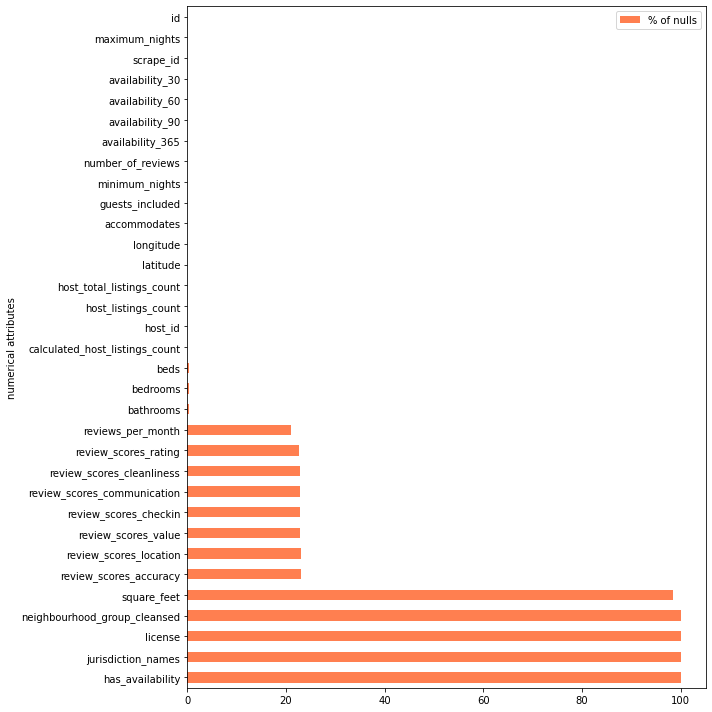

In [66]:
# Plot % of null values in numercial variables
num_nulls.plot.barh(figsize=(10,10), x='numerical attributes', y='% of nulls', color='coral')
save_fig('num_nulls')
plt.show()

Saving figure attribute_histogram_plots


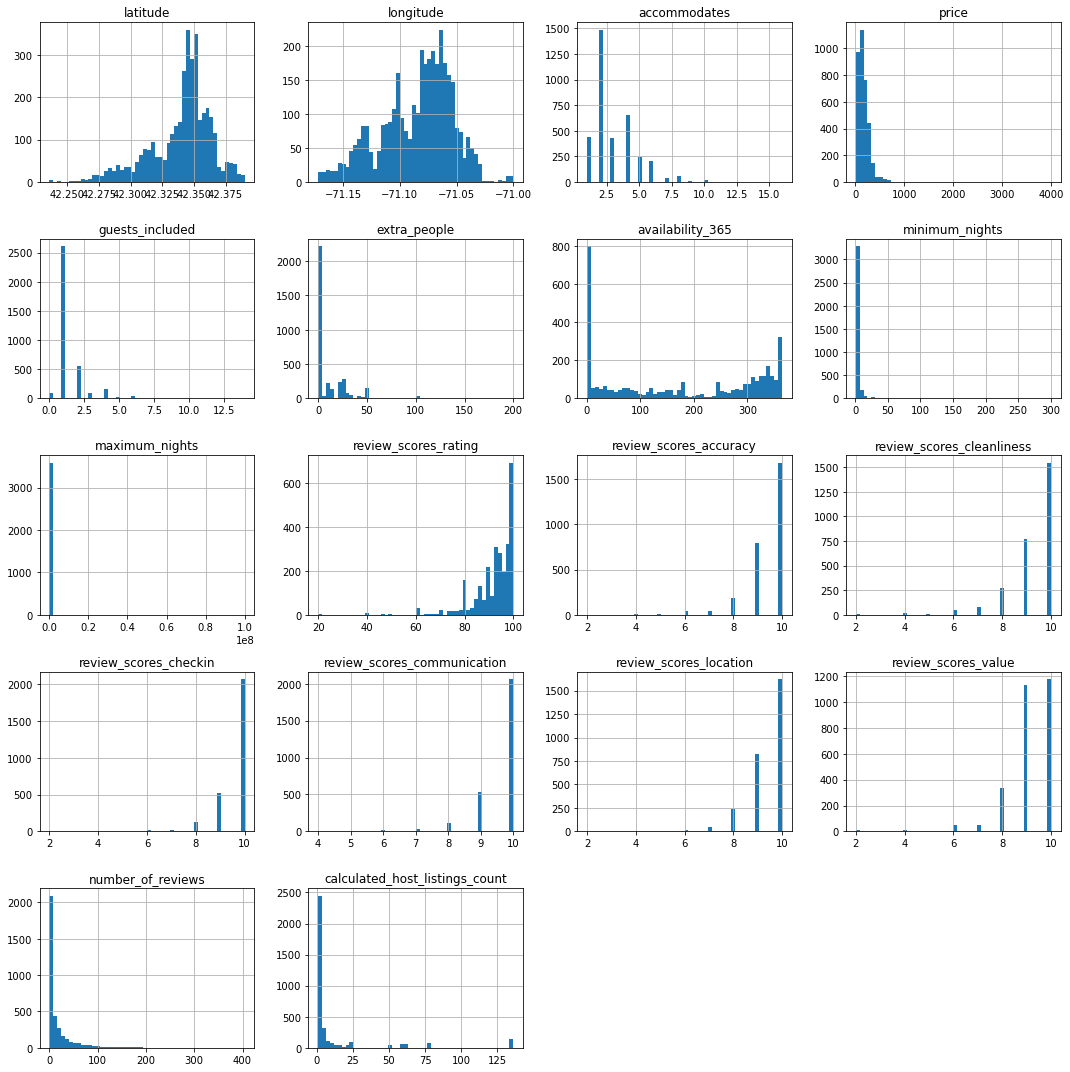

In [74]:
# Plot histograms of numerical attributes

update_listings.hist(bins=50, figsize=(15,15))
save_fig("attribute_histogram_plots")
plt.show()

## Categorical attributes

In [67]:
# Select the categorical features
cat_attribs = listings.select_dtypes(include=['object'])
cat_attribs = cat_attribs[cat_attribs.columns]

In [68]:
# Create a table of missing numerical data with percentage
cat_null_total = cat_attribs.isnull().sum().sort_values(ascending=False)
cat_null_pct = (cat_attribs.isnull().sum() / cat_attribs.isnull().count() * 100).sort_values(ascending=False)
cat_nulls = pd.concat([cat_null_total, cat_null_pct], axis=1, keys=['nulls', '% of nulls']).reset_index().rename(columns={'index' : 'categorical attributes'})
cat_nulls

,categorical attributes,nulls,% of nulls
0,monthly_price,2697,75.230126
1,weekly_price,2693,75.118550
2,security_deposit,2243,62.566248
3,notes,1975,55.090656
4,interaction,1554,43.347280
...,...,...,...
57,street,0,0.000000
58,neighbourhood_cleansed,0,0.000000
59,state,0,0.000000
60,smart_location,0,0.000000


Saving figure cat_nulls


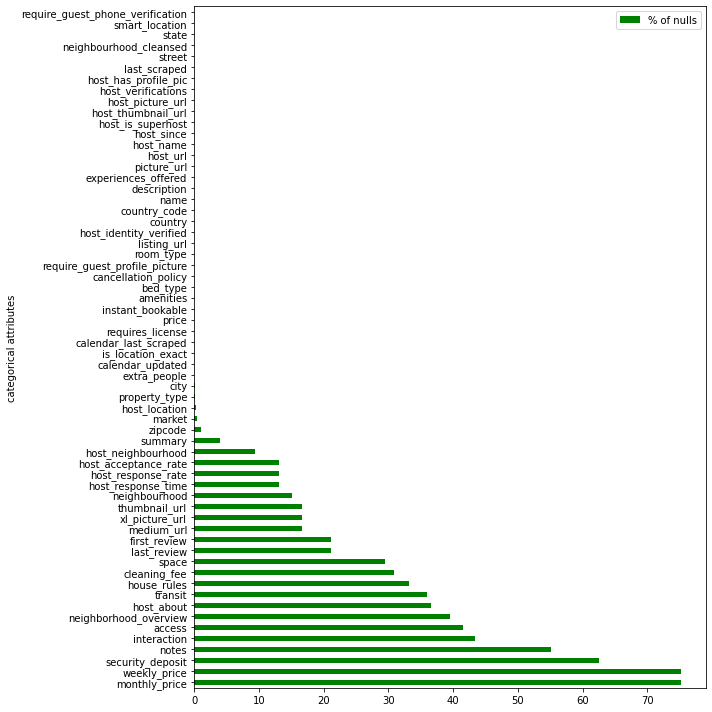

In [69]:
# Plot % of null values in numercial variables
cat_nulls.plot.barh(figsize=(10,10), x='categorical attributes', y='% of nulls', color='green')
save_fig('cat_nulls')
plt.show()

In [70]:
# Provide a set of columns with more than 75% of the values missing
list(listings.columns[listings.isnull().mean() > 0.75])

['neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'has_availability',
 'license',
 'jurisdiction_names']

In [71]:
# Drop columns that have more than 75% missing values and/or are not important for my analysis
update_listings = listings[['latitude', 'longitude', 'neighbourhood_cleansed', 'accommodates', 'room_type', 'bed_type',
                            'price', 'guests_included', 'extra_people', 'availability_365', 'minimum_nights', 'maximum_nights',
                            'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                            'review_scores_communication', 'review_scores_location', 'review_scores_value',
                            'number_of_reviews', 'instant_bookable', 'cancellation_policy', 'calculated_host_listings_count']]

In [73]:
# Convert dollar values to number

update_listings['price'] = update_listings['price'].replace('\$|,', '', regex=True)
update_listings['price'] = pd.to_numeric(update_listings['price'])
update_listings['extra_people'] = update_listings['extra_people'].replace('\$|,', '', regex=True)
update_listings['extra_people'] = pd.to_numeric(update_listings['extra_people'])

In [75]:
# Remove price values above $500

update_listings = update_listings[update_listings['price'] <= 500]

In [76]:
update_listings.head()

,latitude,longitude,neighbourhood_cleansed,accommodates,room_type,bed_type,price,guests_included,extra_people,availability_365,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,instant_bookable,cancellation_policy,calculated_host_listings_count
0,42.282619,-71.133068,Roslindale,4,Entire home/apt,Real Bed,250.0,1,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,f,moderate,1
1,42.286241,-71.134374,Roslindale,2,Private room,Real Bed,65.0,0,0.0,359,...,10.0,9.0,10.0,10.0,9.0,9.0,36,t,moderate,1
2,42.292438,-71.135765,Roslindale,2,Private room,Real Bed,65.0,1,20.0,319,...,10.0,9.0,10.0,10.0,9.0,10.0,41,f,moderate,1
3,42.281106,-71.121021,Roslindale,4,Private room,Real Bed,75.0,2,25.0,98,...,10.0,10.0,10.0,10.0,10.0,10.0,1,f,moderate,1
4,42.284512,-71.136258,Roslindale,2,Private room,Real Bed,79.0,1,0.0,334,...,10.0,10.0,10.0,10.0,9.0,10.0,29,f,flexible,1


In [77]:
update_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3519 entries, 0 to 3584
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        3519 non-null   float64
 1   longitude                       3519 non-null   float64
 2   neighbourhood_cleansed          3519 non-null   object 
 3   accommodates                    3519 non-null   int64  
 4   room_type                       3519 non-null   object 
 5   bed_type                        3519 non-null   object 
 6   price                           3519 non-null   float64
 7   guests_included                 3519 non-null   int64  
 8   extra_people                    3519 non-null   float64
 9   availability_365                3519 non-null   int64  
 10  minimum_nights                  3519 non-null   int64  
 11  maximum_nights                  3519 non-null   int64  
 12  review_scores_rating            27

# Q1: What's it like staying in Boston?

Saving figure neighborhoods


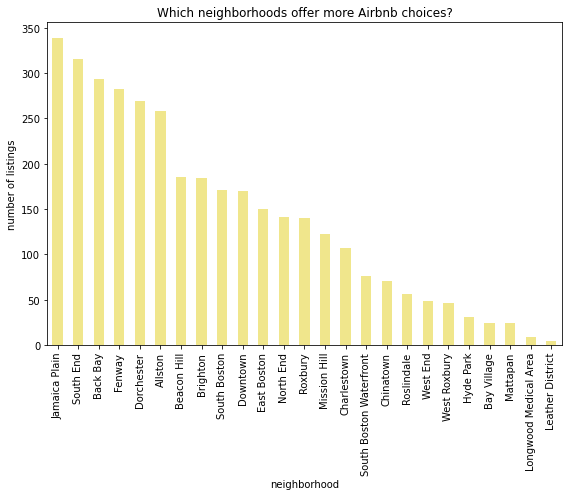

In [78]:
# Neighborhoods with the most listings
plt.figure(figsize=(8,7))
plt.title('Which neighborhoods offer more Airbnb choices?')
update_listings.groupby('neighbourhood_cleansed')['price'].count().sort_values(ascending=False).plot(kind='bar', color='khaki')
plt.xlabel('neighborhood')
plt.ylabel('number of listings')
save_fig("neighborhoods")
plt.show()

Saving figure most_expensive_neighborhoods


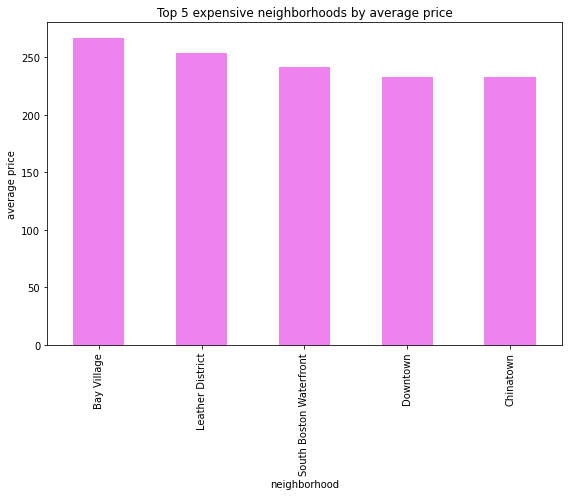

In [79]:
# Five most expensive neighborhoods by avarage price
plt.figure(figsize=(8,7))
plt.title('Top 5 expensive neighborhoods by average price')
update_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending = False).head(5).plot(kind='bar', color='violet')
plt.xlabel('neighborhood')
plt.ylabel('average price')
save_fig("most_expensive_neighborhoods")
plt.show()

Saving figure listing_prices_scatterplot


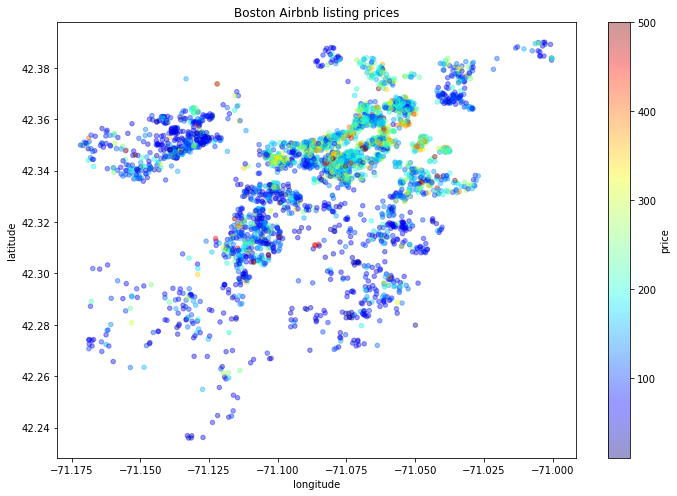

In [80]:
# Plot geographical data
update_listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, c="price", cmap=plt.get_cmap("jet"), figsize=(10,7), colorbar=True, sharex=False)
plt.title('Boston Airbnb listing prices')
save_fig("listing_prices_scatterplot")
plt.show()

There are 797481 words in the combination of all descriptions.


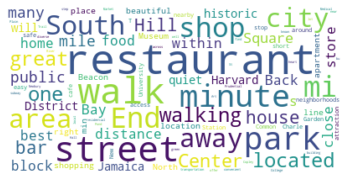

In [81]:
# Join all descriptions of each neighborhood:
text = listings[['neighbourhood_cleansed', 'neighborhood_overview']]

# Now I'll combine all descriptions into one big text and create a big fat cloud to see which characteristics are most common in these neighborhoods

update_text = " ".join(str(desc) for desc in text['neighborhood_overview'])
print ("There are {} words in the combination of all descriptions.".format(len(update_text)))

# Create a stopword list
stopwords = set(STOPWORDS)
stopwords.update(['Airbnb', 'nan', 'Boston', 'neighborhood', 'Roslindale', 'Jamaica Plain', 'Mission Hill', 'Longwood Medical Area', 'Bay Village', 'Leather District',
                  'Chinatown', 'North End', 'Roxbury', 'South End', 'Back Bay', 'East Boston', 'Charlestown', 'West End', 'Beacon Hill', 'Downtown',
                  'Fenway', 'Brighton', 'West Roxbury', 'Hyde Park', 'Mattapan', 'Dorchester', 'South Boston Waterfront', 'South Boston', 'Allston'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, collocations=False, background_color="white").generate(update_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("images/DSND_Project_1/neighborhood_wordcloud.png")
plt.show()

# Q2: How do people rate Boston Airbnbs in general?

In [82]:
reviews = pd.read_csv('/Users/phoil/Downloads/ML/DSND_Term2/lessons/CRISP_DM/Boston AirBnB/reviews.csv')

In [83]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [84]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


In [85]:
print("There are {} observations and {} features in this dataset. \n".format(reviews.shape[0], reviews.shape[1]))

print("There are {} numerical features in this dataset such as {}. \n".format(len(reviews.select_dtypes(['float', 'int']).columns),
                                                                           ", ".join(list(reviews.select_dtypes(['float', 'int']).columns)[0:5])))

print("There are {} categorical features in this dataset such as {}. \n".format(len(reviews.select_dtypes(['object']).columns),
                                                                           ", ".join(list(reviews.select_dtypes(['object']).columns)[0:5])))

There are 68275 observations and 6 features in this dataset. 

There are 3 numerical features in this dataset such as listing_id, id, reviewer_id. 

There are 3 categorical features in this dataset such as date, reviewer_name, comments. 



In [86]:
# Drop rows with missing comments
reviews.dropna(subset=['comments'], axis=0, inplace=True)

# Use TextBlob for sentiment analysis
reviews['polarity'] = ''

for i, x in reviews['comments'].iteritems():
    label = TextBlob(x)
    reviews['polarity'][i] = label.sentiment.polarity
    reviews['polarity'] = pd.to_numeric(reviews['polarity'])

In [87]:
# Create a function to give polarity semantic labels
def polarity_to_label(x):
    """
    Parametrs:
    x (float): the polarity of a comment
    
    Returns:
    One of the three labels "good", "neutral", and "bad" which represents polarity ranging [-1,1]

    """
    if (x < 0):
        return 'bad'
    elif (x == 0):
        return 'neutral'
    elif (0 < x):
        return 'good'
    
reviews['label'] = reviews['polarity'].apply(polarity_to_label)

In [88]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity,label
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,0.388021,good
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,0.600000,good
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,0.200521,good
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,0.383333,good
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,0.466667,good


Saving figure labels


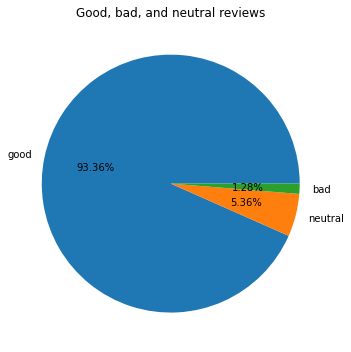

In [89]:
plt.figure(figsize=(8,5))
plt.title('Good, bad, and neutral reviews')
reviews['label'].value_counts().plot(kind='pie', autopct='%1.2f%%')
save_fig('labels')
plt.ylabel('');

In [90]:
reviews[reviews['label'] == 'good']['listing_id'].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            68263, 68265, 68266, 68267, 68268, 68269, 68271, 68272, 68273,
            68274],
           dtype='int64', length=63693)

In [91]:
# Let's read a random good comment
reviews.loc[9]['comments']

"Our stay at Islam's place was fantastic. We couldn't have asked for a better value on location and amenities. We felt very much at home and comfortable at his place and would be quick to stay with him again if we return to Boston!\r\n\r\nIslam was always quick to respond to any questions or concerns we had and very accommodating at every point in our trip! Truly a wonderful place and a lovely host!"

In [92]:
reviews[reviews['label'] == 'bad']['listing_id'].index

Int64Index([   20,    24,    46,    59,    64,   213,   369,   424,   430,
              500,
            ...
            67307, 67478, 67529, 67535, 67673, 67726, 67977, 68038, 68111,
            68200],
           dtype='int64', length=871)

In [93]:
# Let's read a random bad comment
reviews.loc[59]['comments']

"Hard tofind parking.  One night's sleep is alright.  We didn't get to use the one only bathroom, which is shared by all.  There are 4 rooms with a total of 8 people, so it's like sharing one bathroom with 8 people."

There are 476796 words in the combination of all descriptions.


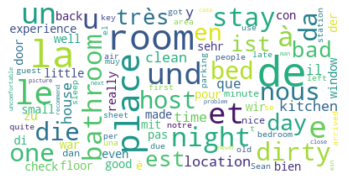

In [94]:
# Join all descriptions of each bad comment:
bad_comments = reviews[reviews['label'] == 'bad']
comments = bad_comments[['listing_id', 'comments']]

# Now I'll combine all descriptions into one big text and create a big fat cloud to see which characteristics are most common in these bad comments
update_comments = " ".join(str(desc) for desc in comments['comments'])
print ("There are {} words in the combination of all descriptions.".format(len(update_comments)))

# Create a stopword list
stopwords = set(STOPWORDS)
stopwords.update(['Airbnb', 'nan', 'Boston', 'neighborhood', 'apartment'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, collocations=False, background_color="white").generate(update_comments)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("images/DSND_Project_1/comments.png")
plt.show()

# Q3: What are the important features that influence price?

In [95]:
# Drop neighborhood column
update_listings.drop('neighbourhood_cleansed', axis=1, inplace=True)

In [96]:
update_listings.head()

,latitude,longitude,accommodates,room_type,bed_type,price,guests_included,extra_people,availability_365,minimum_nights,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,instant_bookable,cancellation_policy,calculated_host_listings_count
0,42.282619,-71.133068,4,Entire home/apt,Real Bed,250.0,1,0.0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,f,moderate,1
1,42.286241,-71.134374,2,Private room,Real Bed,65.0,0,0.0,359,2,...,10.0,9.0,10.0,10.0,9.0,9.0,36,t,moderate,1
2,42.292438,-71.135765,2,Private room,Real Bed,65.0,1,20.0,319,3,...,10.0,9.0,10.0,10.0,9.0,10.0,41,f,moderate,1
3,42.281106,-71.121021,4,Private room,Real Bed,75.0,2,25.0,98,1,...,10.0,10.0,10.0,10.0,10.0,10.0,1,f,moderate,1
4,42.284512,-71.136258,2,Private room,Real Bed,79.0,1,0.0,334,2,...,10.0,10.0,10.0,10.0,9.0,10.0,29,f,flexible,1


In [97]:
# Preprocess categorical features
cat_cols = list(update_listings.select_dtypes(include=['object']).columns)

one_hot = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
cat_1hot = one_hot.fit_transform(update_listings[cat_cols])
cat_1hot

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [98]:
new_cat_cols = one_hot.get_feature_names(cat_cols) # Get feature names
new_cat_cols

array(['room_type_Private room', 'room_type_Shared room',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'instant_bookable_t',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_30'], dtype=object)

In [99]:
# Standardize numeric features
num_cols = list(update_listings.select_dtypes(include=['number']).columns)
num_cols.remove('price')

scaler = StandardScaler()
num_tr = scaler.fit_transform(update_listings[num_cols])
num_tr

array([[-2.3348608 , -1.51865092,  0.58424046, ...,         nan,
        -0.537251  , -0.39953566],
       [-2.18718831, -1.55987893, -0.5773088 , ..., -0.16653888,
         0.46835028, -0.39953566],
       [-1.93452974, -1.60379817, -0.5773088 , ...,  0.82144666,
         0.60801712, -0.39953566],
       ...,
       [ 1.29994919,  0.43120151,  0.58424046, ...,         nan,
        -0.537251  , -0.39953566],
       [ 1.84851926,  0.12743523, -0.5773088 , ..., -2.14250996,
        -0.48138426, -0.39953566],
       [ 1.957029  ,  0.13592389, -0.5773088 , ...,         nan,
        -0.537251  , -0.33193464]])

In [100]:
# Create final process pipeline
cat_pipe = Pipeline([('one-hot-encoder', OneHotEncoder(handle_unknown='error', sparse=False, drop='first'))])
num_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')), ('normalize', StandardScaler())])

full_pipeline = ColumnTransformer([('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)], remainder='passthrough') # for price

transformed_values = full_pipeline.fit_transform(update_listings)
transformed_values

array([[  0.        ,   0.        ,   0.        , ...,  -0.537251  ,
         -0.39953566, 250.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.46835028,
         -0.39953566,  65.        ],
       [  1.        ,   0.        ,   0.        , ...,   0.60801712,
         -0.39953566,  65.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  -0.537251  ,
         -0.39953566, 198.        ],
       [  1.        ,   0.        ,   0.        , ...,  -0.48138426,
         -0.39953566,  65.        ],
       [  1.        ,   0.        ,   0.        , ...,  -0.537251  ,
         -0.33193464,  65.        ]])

In [101]:
full_cols = np.concatenate([new_cat_cols, num_cols, ['price']])
full_cols

array(['room_type_Private room', 'room_type_Shared room',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'instant_bookable_t',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_30', 'latitude', 'longitude',
       'accommodates', 'guests_included', 'extra_people',
       'availability_365', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'number_of_reviews',
       'calculated_host_listings_count', 'price'], dtype=object)

In [102]:
full_listings = pd.DataFrame(transformed_values, columns=full_cols)
full_listings.head()

,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,calculated_host_listings_count,price
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.195512,0.515447,0.536012,0.399102,0.412551,0.548992,-0.14604,-0.537251,-0.399536,250.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.195512,0.515447,-0.390426,0.399102,0.412551,-0.656188,-0.14604,0.468350,-0.399536,65.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.668046,0.515447,-0.390426,0.399102,0.412551,-0.656188,0.97360,0.608017,-0.399536,65.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.904312,0.515447,0.536012,0.399102,0.412551,0.548992,0.97360,-0.509318,-0.399536,75.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.786179,0.515447,0.536012,0.399102,0.412551,-0.656188,0.97360,0.272817,-0.399536,79.0


Saving figure correlations_to_price


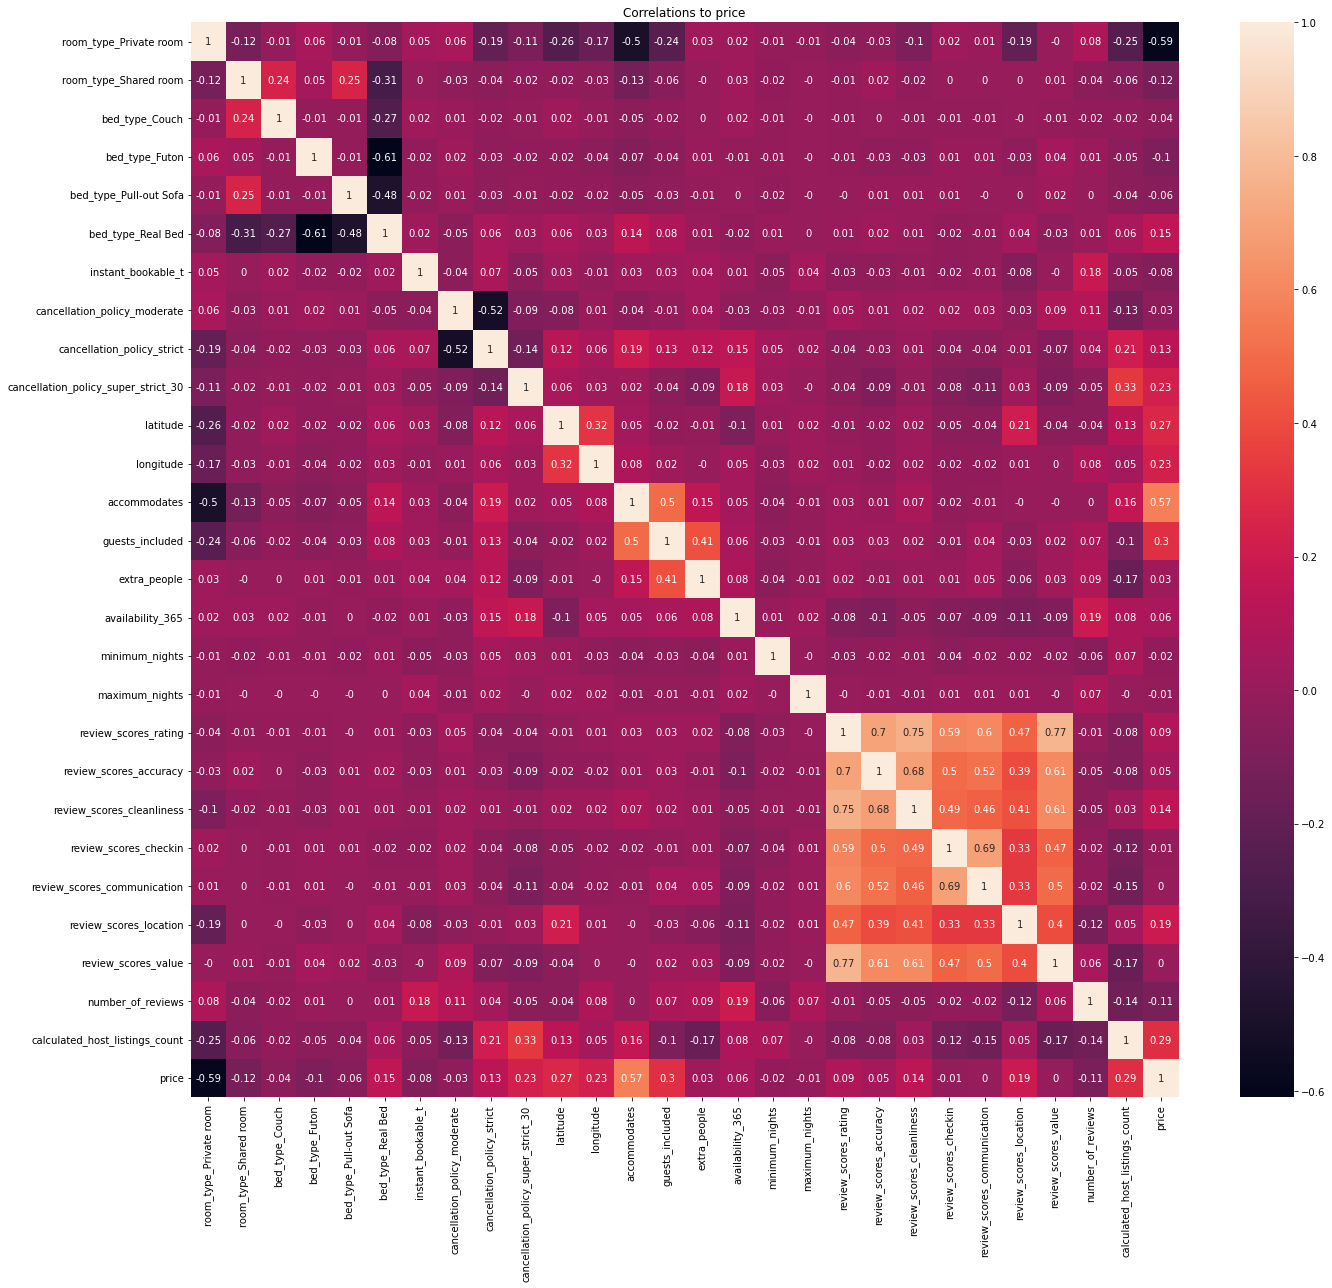

In [103]:
plt.figure(figsize=(20,18))

corr = full_listings.corr()
sns.heatmap(round(corr,2), annot=True)
plt.title('Correlations to price')
save_fig('correlations_to_price')
plt.show()

# 4. Data preparation

In the above section, the necessary data pre-processing has been done for us to be able to create the predictive model. Following, we need to select features that are positively correlated with price at a score higher than the threshold 0 for training machine learning models. Then, divide the data into the response vector, which in this case is the average price of Boston Airbnb’s, and the explanatory matrix, which in this case are all the remaining 23 features. It is a must to divide into the dataset into train and test sets and train the algorithms with the train set before predicting the response of the test set and evaluate.

# 5. Data modeling

## Prepare data for predictions

### Feature selection

Saving figure feature_selection


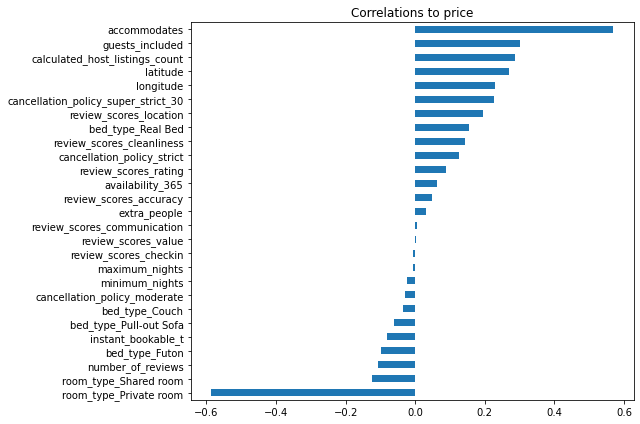

In [104]:
plt.figure(figsize=(9,6))

price_corr = full_listings.corr()['price'].drop('price')
price_corr.sort_values().plot(kind='barh')

plt.title('Correlations to price')
save_fig('feature_selection')
plt.show()

In [105]:
# Filtering features with lower absolute value than a threshold

threshold = 0.0
features = list(price_corr[price_corr<threshold].index.values)
print(features)

['room_type_Private room', 'room_type_Shared room', 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'instant_bookable_t', 'cancellation_policy_moderate', 'minimum_nights', 'maximum_nights', 'review_scores_checkin', 'number_of_reviews']


In [106]:
final_listings = full_listings.drop(columns=full_listings[features], axis=1)
final_listings

,bed_type_Real Bed,cancellation_policy_strict,cancellation_policy_super_strict_30,latitude,longitude,accommodates,guests_included,extra_people,availability_365,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,price
0,1.0,0.0,0.0,-2.334861,-1.518651,0.584240,-0.408731,-0.574936,-1.263896,0.195512,0.515447,0.536012,0.412551,0.548992,-0.14604,-0.399536,250.0
1,1.0,0.0,0.0,-2.187188,-1.559879,-0.577309,-1.383866,-0.574936,1.265724,0.195512,0.515447,-0.390426,0.412551,-0.656188,-0.14604,-0.399536,65.0
2,1.0,0.0,0.0,-1.934530,-1.603798,-0.577309,-0.408731,0.484969,0.983872,0.668046,0.515447,-0.390426,0.412551,-0.656188,0.97360,-0.399536,65.0
3,1.0,0.0,0.0,-2.396531,-1.138367,0.584240,0.566404,0.749945,-0.573359,0.904312,0.515447,0.536012,0.412551,0.548992,0.97360,-0.399536,75.0
4,1.0,0.0,0.0,-2.257665,-1.619354,-0.577309,-0.408731,-0.574936,1.089566,0.786179,0.515447,0.536012,0.412551,-0.656188,0.97360,-0.399536,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,1.0,1.0,0.0,1.674891,0.036766,0.003466,-0.408731,0.696949,1.244585,-0.277021,0.515447,0.536012,0.412551,-1.861367,-0.14604,-0.162932,69.0
3515,1.0,1.0,0.0,0.310529,-1.053589,-0.577309,-0.408731,-0.574936,1.300955,0.195512,0.515447,0.536012,0.412551,0.548992,-0.14604,-0.365735,150.0
3516,1.0,0.0,0.0,1.299949,0.431202,0.584240,-0.408731,-0.574936,-0.982044,0.195512,0.515447,0.536012,0.412551,0.548992,-0.14604,-0.399536,198.0
3517,1.0,1.0,0.0,1.848519,0.127435,-0.577309,-0.408731,1.014921,0.518817,-0.277021,-0.656296,-1.316864,-1.088758,-1.861367,-2.38532,-0.399536,65.0


In [107]:
final_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3519 entries, 0 to 3518
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   bed_type_Real Bed                    3519 non-null   float64
 1   cancellation_policy_strict           3519 non-null   float64
 2   cancellation_policy_super_strict_30  3519 non-null   float64
 3   latitude                             3519 non-null   float64
 4   longitude                            3519 non-null   float64
 5   accommodates                         3519 non-null   float64
 6   guests_included                      3519 non-null   float64
 7   extra_people                         3519 non-null   float64
 8   availability_365                     3519 non-null   float64
 9   review_scores_rating                 3519 non-null   float64
 10  review_scores_accuracy               3519 non-null   float64
 11  review_scores_cleanliness     

### Split train and test sets

In [108]:
X = final_listings.drop('price', axis=1)
y = final_listings[['price']]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

print('Training set:', X_train.shape, ',', y_train.shape)
print('Test set:', X_test.shape, ',', y_test.shape)

Training set: (2815, 16) , (2815, 1)
Test set: (704, 16) , (704, 1)


## Select and train a model

### Linear Regression

In [110]:
# Create Linear Regression model from X_train and y_train
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Get predictions from X_test
lr_preds = lin_reg.predict(X_test)

# Calculate root mean squared error between the y_test and predictions
lr_mae = mean_absolute_error(y_test, lr_preds)
print(f"{lr_mae:.3f}")

# Calculate r2 squared score
lr_r2_score = r2_score(y_test, lr_preds)
print(f"{lr_r2_score:.3f}")

49.185
0.484


### Decision Tree

In [111]:
# Create Decision Tree model from X_train and y_train
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Get predictions from X_test
tree_preds = tree_reg.predict(X_test)

# Calculate root mean squared error between the y_test and predictions
tree_mae = mean_absolute_error(y_test, tree_preds)
print(f"{tree_mae:.3f}")

# Calculate r2 squared score
tree_r2_score = r2_score(y_test, tree_preds)
print(f"{tree_r2_score:.3f}")

54.646
0.297


### Random Forest Regressor

In [112]:
# Create Random Forest model from X_train and y_train
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Get predictions from X_test
rf_preds = rf_reg.predict(X_test)

# Calculate root mean squared error between the y_test and predictions
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"{rf_mae:.3f}")

# Calculate r2 squared score
rf_r2_score = r2_score(y_test, rf_preds)
print(f"{rf_r2_score:.3f}")

39.870
0.609


# 6. Evaluate model performance

In [113]:
scores = pd.DataFrame({'R-squared' : [lr_r2_score, tree_r2_score, rf_r2_score],
                       'Mean Absolute Error' : [lr_mae, tree_mae, rf_mae], 
                       'Predicted average price' : [lr_preds.mean(), tree_preds.mean(), rf_preds.mean()]},
                      index=['Linear Regression', 'Decision Tree', 'Random Forest'])
scores

,R-squared,Mean Absolute Error,Predicted average price
Linear Regression,0.484168,49.185116,158.182441
Decision Tree,0.297052,54.646307,156.815341
Random Forest,0.609194,39.869844,160.826662


In [114]:
y_test.mean()

price    163.87642
dtype: float64

In [117]:
weights = pd.DataFrame({'feature name' : final_listings.drop(columns=['price']).columns,
                        'weights' : rf_reg.feature_importances_}).sort_values('weights', ascending=False)

In [118]:
# Sort feature importance in Random Forest model

weights.style.background_gradient(cmap='Blues')

,feature name,weights
5,accommodates,0.352731
3,latitude,0.188586
4,longitude,0.154694
8,availability_365,0.088478
15,calculated_host_listings_count,0.051745
9,review_scores_rating,0.038741
7,extra_people,0.028793
6,guests_included,0.025801
11,review_scores_cleanliness,0.015284
1,cancellation_policy_strict,0.011194
